In [1]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# Load preprocessed dataset 
df = pd.read_csv('C:\\Users\\lkmah\\healthcare_readmission_project\\data\\processed\\diabetes_preprocessed.csv')

# Split into X and y
X = df.drop('readmitted_binary', axis=1)
y = df['readmitted_binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [9]:
y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]

In [10]:
# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.44      0.03      0.05      2271

    accuracy                           0.89     20354
   macro avg       0.66      0.51      0.50     20354
weighted avg       0.84      0.89      0.84     20354




Confusion Matrix:


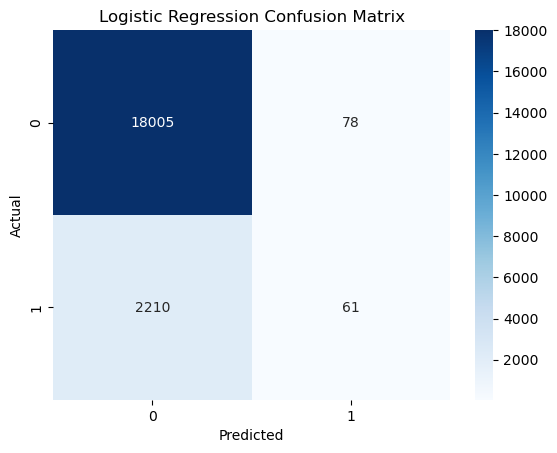

In [11]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [12]:
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


ROC AUC Score: 0.6364074234437306


In [14]:
# Clean up column names: remove or replace [ ] < >
X_train.columns = X_train.columns.str.replace(r"[<>[\]]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[<>[\]]", "_", regex=True)

In [17]:
# Calculate class imbalance ratio
neg, pos = y_train.value_counts()
scale = neg / pos
print(f"Class 0: {neg}, Class 1: {pos}, scale_pos_weight: {scale:.2f}")

Class 0: 72326, Class 1: 9086, scale_pos_weight: 7.96


In [18]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale,
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

In [20]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.68      0.78     18083
           1       0.18      0.57      0.28      2271

    accuracy                           0.67     20354
   macro avg       0.55      0.62      0.53     20354
weighted avg       0.84      0.67      0.73     20354

ROC AUC Score: 0.67375325913513


In [22]:
import shap
shap.initjs()

In [23]:
# Create explainer
explainer = shap.TreeExplainer(xgb_model)

In [24]:
# Pick 100 random test samples to speed it up
X_sample = X_test.sample(100, random_state=42)

In [25]:
# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

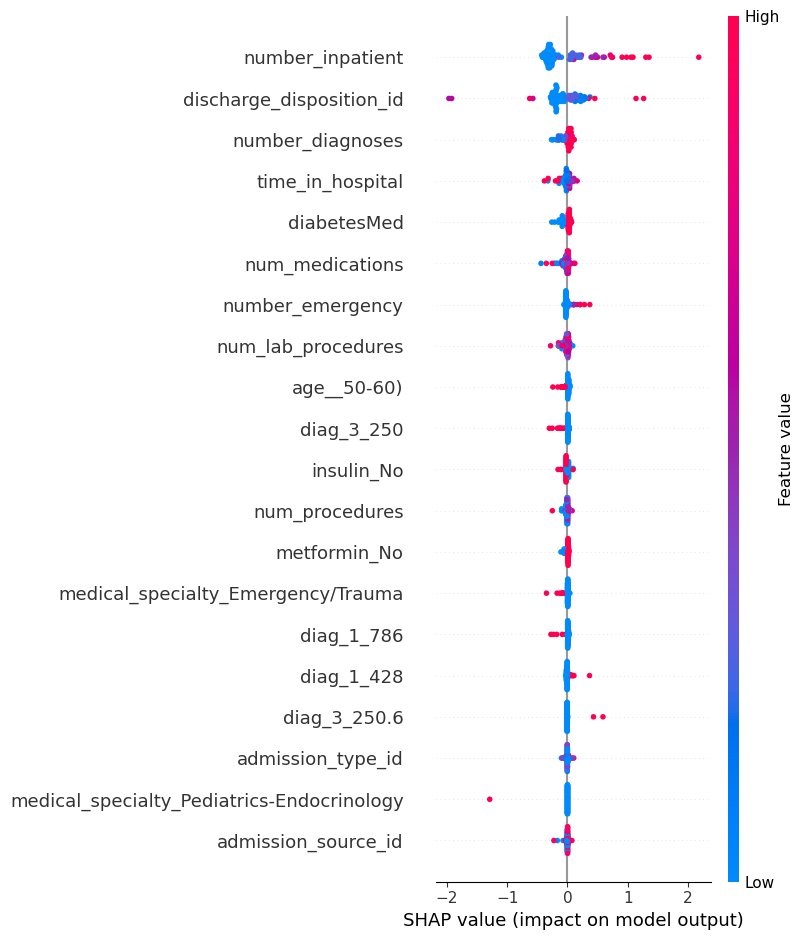

In [26]:
# Global explanation: feature importance
shap.summary_plot(shap_values, X_sample)

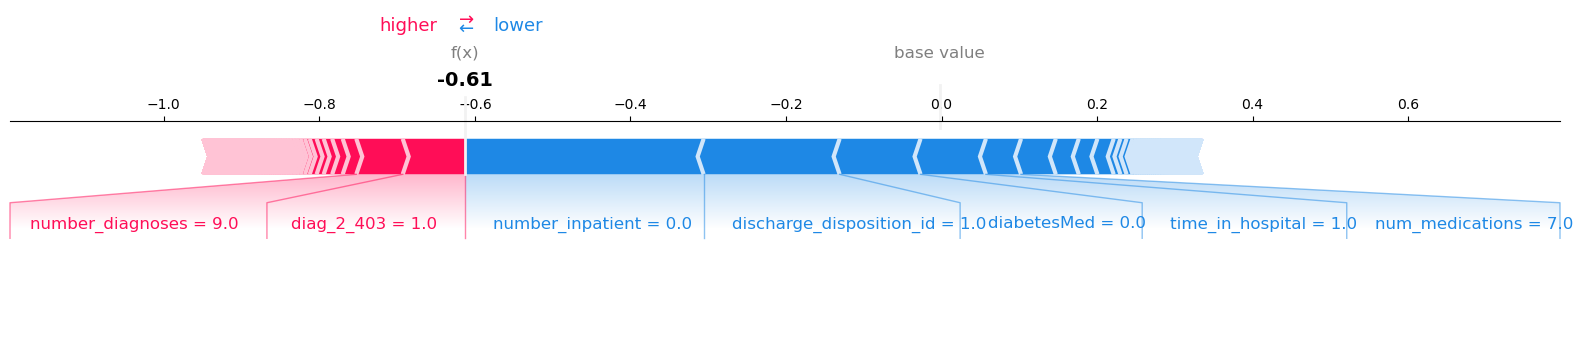

In [27]:
#Individual explanation
shap.force_plot(
    explainer.expected_value, shap_values[0], X_sample.iloc[0], matplotlib=True
)

In [28]:
import joblib

# Save model
joblib.dump(xgb_model, 'diabetes_model.pkl')

# Optional: if you scaled the data
joblib.dump(scaler, 'scaler.pkl')

# Save sample X_test for SHAP (background)
X_test.sample(100, random_state=42).to_csv('shap_background.csv', index=False)


In [36]:
X_train.head(1).to_csv('../data/processed/template_input.csv', index=False)


In [37]:
# Reload the file
template_check = pd.read_csv('../data/processed/template_input.csv')

In [38]:
# Compare columns with original
print((template_check.columns == X_train.columns).all()) 

True


In [39]:
import csv

X_train.head(1).to_csv(
    '../data/processed/template_input.csv',
    index=False,
    quoting=csv.QUOTE_NONNUMERIC
)


In [40]:
# Load saved template
template = pd.read_csv('../data/processed/template_input.csv')

# Compare with training set features
assert set(template.columns) == set(X_train.columns), "Template column mismatch!"


In [41]:
X_train.iloc[0:1].to_csv('../data/processed/template_input.csv', index=False)


In [42]:
template = pd.read_csv('../data/processed/template_input.csv')
print(template.columns.tolist())


['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'age__10-20)', 'age__20-30)', 'age__30-40)', 'age__40-50)', 'age__50-60)', 'age__60-70)', 'age__70-80)', 'age__80-90)', 'age__90-100)', 'medical_specialty_Anesthesiology', 'medical_specialty_Anesthesiology-Pediatric', 'medical_specialty_Cardiology', 'medical_specialty_Cardiology-Pediatric', 'medical_specialty_DCPTEAM', 'medical_specialty_Dentistry', 'medical_specialty_Dermatology', 'medical_specialty_Emergency/Trauma', 'medical_specialty_Endocrinology', 'medical_specialty_Endocrinology-Metabolism', 'medical_specialty_Family/GeneralPractice', 'medical_specialty_Gastroenterology', 'medical_specialty_Gynecology', 'medical_specialty_Hematology', 'medical_specialty_

In [43]:
import csv

# Export a safe template preserving special characters
X_train.iloc[0:1].to_csv(
    '../data/processed/template_input.csv',
    index=False,
    quoting=csv.QUOTE_NONNUMERIC
)


In [44]:
template = pd.read_csv('../data/processed/template_input.csv')
print(template.columns.tolist())


['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'age__10-20)', 'age__20-30)', 'age__30-40)', 'age__40-50)', 'age__50-60)', 'age__60-70)', 'age__70-80)', 'age__80-90)', 'age__90-100)', 'medical_specialty_Anesthesiology', 'medical_specialty_Anesthesiology-Pediatric', 'medical_specialty_Cardiology', 'medical_specialty_Cardiology-Pediatric', 'medical_specialty_DCPTEAM', 'medical_specialty_Dentistry', 'medical_specialty_Dermatology', 'medical_specialty_Emergency/Trauma', 'medical_specialty_Endocrinology', 'medical_specialty_Endocrinology-Metabolism', 'medical_specialty_Family/GeneralPractice', 'medical_specialty_Gastroenterology', 'medical_specialty_Gynecology', 'medical_specialty_Hematology', 'medical_specialty_

In [49]:
# Check columns with weird names
bad_cols = [col for col in X_train.columns if '__' in col]
print(bad_cols)


['age__10-20)', 'age__20-30)', 'age__30-40)', 'age__40-50)', 'age__50-60)', 'age__60-70)', 'age__70-80)', 'age__80-90)', 'age__90-100)', 'max_glu_serum__300', 'A1Cresult__8']


In [50]:
import re

def fix_column_name(col):
    # Fix age brackets
    col = re.sub(r'age__', 'age_[', col)
    col = re.sub(r'\)', ')', col)
    col = re.sub(r'([0-9]+-[0-9]+)\)', r'\1)', col)
    if 'age_[' in col:
        col = col.replace(')', ')') + ')' if not col.endswith(')') else col

    # Fix A1Cresult
    col = col.replace('A1Cresult__8', 'A1Cresult_>8')
    col = col.replace('A1Cresult__7', 'A1Cresult_>7')
    col = col.replace('__', '_')  # fallback

    return col

# Apply fixes
X_train.columns = [fix_column_name(c) for c in X_train.columns]

# Save clean template
X_train.iloc[0:1].to_csv('../data/processed/template_input.csv', index=False, encoding='utf-8')


In [51]:
template = pd.read_csv('../data/processed/template_input.csv')
print(template.columns.tolist())


['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)', 'age_[90-100)', 'medical_specialty_Anesthesiology', 'medical_specialty_Anesthesiology-Pediatric', 'medical_specialty_Cardiology', 'medical_specialty_Cardiology-Pediatric', 'medical_specialty_DCPTEAM', 'medical_specialty_Dentistry', 'medical_specialty_Dermatology', 'medical_specialty_Emergency/Trauma', 'medical_specialty_Endocrinology', 'medical_specialty_Endocrinology-Metabolism', 'medical_specialty_Family/GeneralPractice', 'medical_specialty_Gastroenterology', 'medical_specialty_Gynecology', 'medical_specialty_Hematology', 'medical_specialty_

In [54]:
import re

def fix_column_name(col):
    col = col.replace('__', '_')
    col = col.replace('A1Cresult__8', 'A1Cresult_>8')
    col = col.replace('max_glu_serum__300', 'max_glu_serum_>300')

    # Fix age column: e.g., age__10-20) → age_[10-20)
    col = re.sub(r'age__([0-9]+-[0-9]+)\)', r'age_[\1)', col)

    return col

# Apply to both X_train and X_test
X_train.columns = [fix_column_name(c) for c in X_train.columns]
X_test.columns = [fix_column_name(c) for c in X_test.columns]


In [53]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# Rescale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: Handle class imbalance again
scale = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale)
model.fit(X_train_scaled, y_train)

# Save new model and scaler
joblib.dump(model, '../models/diabetes_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- A1Cresult_8
Feature names seen at fit time, yet now missing:
- A1Cresult_>8


In [56]:
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

print("🧩 Missing in X_test:\n", missing_in_test)
print("🧩 Extra in X_test:\n", extra_in_test)


🧩 Missing in X_test:
 {'A1Cresult_>8'}
🧩 Extra in X_test:
 {'A1Cresult_8'}


In [57]:
# Rename incorrect column
X_test.rename(columns={'A1Cresult_8': 'A1Cresult_>8'}, inplace=True)

# Add any other missing columns just to be safe
missing_in_test = set(X_train.columns) - set(X_test.columns)
for col in missing_in_test:
    X_test[col] = 0

# Reorder columns to match X_train
X_test = X_test[X_train.columns]

# Final check
assert set(X_train.columns) == set(X_test.columns), "❌ Column mismatch still exists!"
print("✅ Columns aligned successfully!")


✅ Columns aligned successfully!


In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Handle imbalance
scale = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize and train model
xgb_model = XGBClassifier(scale_pos_weight=scale, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.93      0.68      0.78     18083
           1       0.18      0.57      0.28      2271

    accuracy                           0.67     20354
   macro avg       0.55      0.62      0.53     20354
weighted avg       0.84      0.67      0.73     20354

ROC AUC Score: 0.67375325913513


In [61]:
import joblib
import pandas as pd

# Save model
joblib.dump(xgb_model, '../models/diabetes_model.pkl')

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')

# Save SHAP background (optional: 100 sample rows)
background = pd.DataFrame(X_train_scaled, columns=X_train.columns).sample(100, random_state=42)
background.to_csv('../data/processed/shap_background.csv', index=False)

# Save column template (0s DataFrame)
template = pd.DataFrame(columns=X_train.columns)
template.loc[0] = 0
template.to_csv('../data/processed/template_input.csv', index=False)
